# Abundance Matching

### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from tqdm import trange
import pymc3 as pm
import theano
import theano.tensor as tt
from astropy import units as u
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance
import os


%matplotlib inline

In [2]:
from astropy.cosmology import Planck15

In [3]:
Planck15.Om0 - Planck15.Ob0

0.2589

In [4]:
0.02236/(0.6727)**2 

0.04941160305095877

## Datos

#### Finkelstein

In [5]:
file = open('Finkelstein/ApJ810_2015/apj810.tsv','r')

k=0
for row in file.readlines():
    if (not '#' in row) and row!="\n":
        break
    else:
        k+=1
file.close()

fink_a = pd.read_csv('Finkelstein/ApJ810_2015/apj810.tsv',sep=";", skiprows=k)
fink_a = fink_a.iloc[2:]
fink_a.ID = [r.replace(" ","") for r in fink_a.ID.values]
fink_a.iloc[:,6:] = fink_a.iloc[:,6:].astype(float)
fink_a

,_RAJ2000,_DEJ2000,ID,HRG14,RAJ2000,DEJ2000,zphot,b_zphot,B_zphot,1500Mag,b_1500Mag,B_1500Mag
2,053.12903194,-27.77220889,z4_GSD_7082,HRG14 J033230.97-274620.0,053.129032,-27.772209,2.83,1.3,4.33,-17.8,-18.37,-17.25
3,053.10157389,-27.80856306,z4_GSD_18977,HRG14 J033224.38-274830.8,053.101574,-27.808563,3.13,1.25,4.51,-17.86,-18.29,-16.94
4,053.10408389,-27.81275389,z4_GSD_20362,HRG14 J033224.98-274845.9,053.104084,-27.812754,3.23,3.1,4.38,-18.93,-19.51,-18.63
5,053.03509500,-27.78334389,z4_GSD_10712,HRG14 J033208.42-274700.0,053.035095,-27.783344,3.28,0.86,4.5,-16.96,-17.43,-16
6,053.08642194,-27.84164000,z4_GSD_29649,HRG14 J033220.74-275029.9,053.086422,-27.841640,3.3,2.1,4.08,-18.27,-18.93,-18.12
...,...,...,...,...,...,...,...,...,...,...,...,...
7443,053.26932500,-27.84805500,z8_PAR2_957,HRG14 J033304.64-275053.0,053.269325,-27.848055,7.61,7.18,7.85,-19.9,-19.93,-19.74
7444,053.27904500,-27.84109111,z8_PAR2_428,HRG14 J033306.97-275027.9,053.279045,-27.841091,8.21,3.34,9.41,-18.74,-19,-18.53
7445,064.12686194,-24.10006694,z8_MACS0416PAR_797,HRG14 J041630.45-240600.2,064.126862,-24.100067,7.99,6.71,8.29,-18.86,-18.9,-18.73
7446,064.12678500,-24.10031694,z8_MACS0416PAR_851,HRG14 J041630.43-240601.1,064.126785,-24.100317,8.25,7.53,8.67,-18.9,-18.99,-18.67


In [6]:
f = fink_a['1500Mag'].astype(float).unique()
f.sort()
f

array([-22.75, -22.7 , -22.65, -22.63, -22.46, -22.43, -22.35, -22.29,
       -22.25, -22.17, -22.12, -22.11, -22.08, -22.06, -22.05, -22.03,
       -22.  , -21.95, -21.92, -21.91, -21.83, -21.82, -21.8 , -21.78,
       -21.77, -21.74, -21.73, -21.71, -21.69, -21.67, -21.66, -21.65,
       -21.64, -21.63, -21.62, -21.61, -21.6 , -21.59, -21.58, -21.57,
       -21.56, -21.55, -21.54, -21.53, -21.52, -21.51, -21.5 , -21.48,
       -21.47, -21.46, -21.45, -21.44, -21.43, -21.42, -21.41, -21.4 ,
       -21.39, -21.38, -21.37, -21.36, -21.35, -21.34, -21.33, -21.32,
       -21.31, -21.3 , -21.29, -21.28, -21.27, -21.26, -21.24, -21.23,
       -21.22, -21.21, -21.2 , -21.19, -21.18, -21.17, -21.16, -21.15,
       -21.14, -21.13, -21.12, -21.11, -21.1 , -21.09, -21.08, -21.07,
       -21.06, -21.05, -21.04, -21.03, -21.02, -21.01, -21.  , -20.99,
       -20.98, -20.97, -20.96, -20.95, -20.94, -20.93, -20.92, -20.91,
       -20.9 , -20.89, -20.88, -20.87, -20.86, -20.85, -20.84, -20.83,
      

In [7]:
file = open('Finkelstein/ApJ814_2015/apj814.tsv','r')
k=0
for row in file.readlines():
    if (not '#' in row) and row!="\n":
        break
    else:
        k+=1

fink_b = pd.read_csv('Finkelstein/ApJ814_2015/apj814.tsv',sep=";", skiprows=k)
fink_b = fink_b.iloc[2:]
fink_b.ID = [r.replace(" ","") for r in fink_b.ID.values]

fink = pd.merge(fink_a,fink_b, on=['ID','RAJ2000','DEJ2000','_RAJ2000', '_DEJ2000'])
fink

,_RAJ2000,_DEJ2000,ID,HRG14,RAJ2000,DEJ2000,zphot,b_zphot,B_zphot,1500Mag,...,Age,b_Age,B_Age,E(B-V),b_E(B-V),B_E(B-V),SFR,b_SFR,B_SFR,Simbad
0,053.09684000,-27.86607389,z4_GSD_34736,HRG14 J033223.24-275157.9,053.096840,-27.866074,3.51,0.38,3.64,-21.36,...,10,19,101,0.34,0.18,0.34,451,109,434,Simbad
1,053.08689111,-27.84413889,z4_GSD_30292,HRG14 J033220.85-275038.9,053.086891,-27.844139,3.54,0.4,3.7,-21.03,...,57,49,90,0.24,0.16,0.32,132,64,322,Simbad
2,053.08736806,-27.83953500,z4_GSD_29028,HRG14 J033220.97-275022.3,053.087368,-27.839535,3.6,3.48,3.73,-21.03,...,80,80,101,0.10,0.06,0.10,38,25,40,Simbad
3,053.12141389,-27.81462111,z4_GSD_21002,HRG14 J033229.14-274852.6,053.121414,-27.814621,3.63,3.57,3.73,-21.18,...,30,10,30,0.18,0.16,0.24,93,70,152,Simbad
4,053.03123889,-27.78521500,z4_GSD_11269,HRG14 J033207.50-274706.8,053.031239,-27.785215,3.63,3.53,3.77,-21.3,...,49,40,101,0.10,0.10,0.24,45,43,176,Simbad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,189.03248611,+62.21641500,z7_GNW_17001,HRG14 J123607.80+621259.1,189.032486,+62.216415,6.84,6.58,7.03,-21.12,...,404,286,570,0.06,0.02,0.12,22,14,37,Simbad
169,189.36171000,+62.29437306,z7_GNW_24671,HRG14 J123726.81+621739.7,189.361710,+62.294373,6.93,6.27,7.38,-21.22,...,19,10,40,0.10,0.00,0.10,37,11,33,Simbad
170,189.09452806,+62.13554000,z7_GNW_4703,HRG14 J123622.69+620807.9,189.094528,+62.135540,7.19,7.04,7.4,-21.71,...,39,10,49,0.02,0.00,0.10,27,22,61,Simbad
171,189.27339194,+62.32478306,z7_GNW_19939,HRG14 J123705.61+621929.2,189.273392,+62.324783,7.24,6.81,7.69,-21.04,...,10,10,30,0.10,0.00,0.12,34,14,42,Simbad


#### Bouwens

In [8]:
#!head -n 40 'Bouwens 2015/2015bouwensApJ803.tsv'

In [9]:
for z in range(4,9):
    print('Para z=%.1f la Lambda_0 se encuentra entre %.0f - %.0f angstrong' % (z,15000/(1+z),20000/(1+z)))

Para z=4.0 la Lambda_0 se encuentra entre 3000 - 4000 angstrong
Para z=5.0 la Lambda_0 se encuentra entre 2500 - 3333 angstrong
Para z=6.0 la Lambda_0 se encuentra entre 2143 - 2857 angstrong
Para z=7.0 la Lambda_0 se encuentra entre 1875 - 2500 angstrong
Para z=8.0 la Lambda_0 se encuentra entre 1667 - 2222 angstrong


In [10]:
file = open('Bouwens 2015/2015bouwensApJ803.tsv','r')

k=0
for row in file.readlines():
    if (not '#' in row) and row!="\n":
        break
    else:
        k+=1
        
bw2015 = pd.read_csv('Bouwens 2015/2015bouwensApJ803.tsv',sep=";", skiprows=k, usecols=[0,1,2,3,4,5,6,8])
bw2015 = bw2015.iloc[2:]
bw2015.iloc[:,3:] = bw2015.iloc[:,3:].astype(float)
bw2015

,ID,RAJ2000,DEJ2000,F160W,zset,dset,zphot,OCat
2,HUDF092B-3053452227,03 33 05.34,-27 52 22.7,28.83,4,3,3.87,0
3,HUDF092B-3046852195,03 33 04.68,-27 52 19.5,27.11,4,3,3.45,0
4,HUDF092B-3045052182,03 33 04.50,-27 52 18.2,27.75,4,3,3.45,0
5,HUDF092B-3047752095,03 33 04.77,-27 52 09.5,27.77,4,3,2.87,0
6,HUDF092B-3073952111,03 33 07.39,-27 52 11.1,27.29,4,3,3.82,0
...,...,...,...,...,...,...,...,...
10418,GNDJ-2545743169,12 36 25.45,+62 14 31.6,25.93,10,6,10.2,0
10419,GNDJ-2273942274,12 37 22.73,+62 14 22.7,26.75,10,6,9.9,0
10420,GNWJ-0408242996,12 36 04.08,+62 14 29.9,26.75,10,6,9.5,0
10421,XDFJ-3811362435,03 32 38.11,-27 46 24.3,29.46,10,6,9.78,0


<img src="https://cdn.mathpix.com/snip/images/WTuNW8HreMYZDdZBvWGW1rW9nSD4COOjsfjqS6Xq3aY.original.fullsize.png" />

In [11]:
uvf_bw_z4 = pd.read_csv("Bouwens 2015/bowensz4.csv", names=['M','phi','err_phi']) 
uvf_bw_z4['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z4.M.values - 4.62)))
uvf_bw_z5 = pd.read_csv("Bouwens 2015/bowensz5.csv", names=['M','phi','err_phi']) 
uvf_bw_z5['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z5.M.values - 4.62)))
uvf_bw_z6 = pd.read_csv("Bouwens 2015/bowensz6.csv", names=['M','phi','err_phi']) 
uvf_bw_z6['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z6.M.values - 4.62)))
uvf_bw_z7 = pd.read_csv("Bouwens 2015/bowensz7.csv", names=['M','phi','err_phi']) 
uvf_bw_z7['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z7.M.values - 4.62)))
uvf_bw_z8 = pd.read_csv("Bouwens 2015/bowensz8.csv", names=['M','phi','err_phi']) 
uvf_bw_z8['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z8.M.values - 4.62)))

#### Behroozi 2019

In [12]:
uvf_bw_z4.err_phi

0     0.000004
1     0.000009
2     0.000023
3     0.000040
4     0.000063
5     0.000113
6     0.000185
7     0.000255
8     0.000446
9     0.001043
10    0.002229
11    0.003500
12    0.007860
Name: err_phi, dtype: float64

In [13]:
smf_z4=pd.read_csv("umachine-dr1/data/smfs/smf_a0.202435.dat", skiprows=3,sep="\s", engine='python')
smf_z4

,#Log10(SM_Center),Number_Density,Err+,Err-,Satellite_fraction,Err+.1,Err-.1,Q_Number_Density,Err+.2,Err-.2,SM_Left_Edge,SM_Right_Edge
0,7.3,5.828010e-02,1.340610e-02,5.364260e-03,0.184588,0.020796,0.008695,6.037090e-07,7.848220e-06,3.018550e-07,7.2,7.4
1,7.5,4.550130e-02,1.183380e-02,4.624110e-03,0.208553,0.024371,0.007259,2.012360e-06,1.177230e-05,1.308040e-06,7.4,7.6
2,7.7,3.445610e-02,9.932430e-03,3.221800e-03,0.229202,0.027668,0.004103,1.308040e-06,1.499210e-05,1.006180e-07,7.6,7.8
3,7.9,2.533230e-02,7.583800e-03,2.203040e-03,0.241518,0.029517,0.002275,1.710510e-06,1.549520e-05,4.024730e-07,7.8,8.0
4,8.1,1.828770e-02,5.433180e-03,1.660300e-03,0.240898,0.031134,-0.000621,2.515460e-06,1.177230e-05,1.106800e-06,8.0,8.2
5,8.3,1.289730e-02,3.547500e-03,1.174520e-03,0.233709,0.030987,-0.001284,1.710510e-06,1.157110e-05,1.006180e-06,8.2,8.4
6,8.5,9.007040e-03,2.216420e-03,7.972990e-04,0.223935,0.027615,0.000559,2.112980e-06,1.408660e-05,1.609890e-06,8.4,8.6
7,8.7,6.254930e-03,1.306020e-03,5.652730e-04,0.209362,0.025367,-0.000867,4.930290e-06,1.126920e-05,4.427200e-06,8.6,8.8
8,8.9,4.305050e-03,7.402480e-04,3.913040e-04,0.195111,0.020707,0.000613,7.747600e-06,1.187300e-05,7.445750e-06,8.8,9.0
9,9.1,2.925880e-03,4.258160e-04,2.822340e-04,0.184222,0.017312,0.001769,7.646990e-06,1.519340e-05,7.546370e-06,9.0,9.2


In [14]:
uvf_z4=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.202435.dat", skiprows=3,sep="\s", engine='python')
uvf_z5=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.166998.dat", skiprows=3,sep="\s", engine='python')
uvf_z6=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.141685.dat", skiprows=3,sep="\s", engine='python')
uvf_z7=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.126498.dat", skiprows=3,sep="\s", engine='python')
uvf_z8=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.109623.dat", skiprows=3,sep="\s", engine='python')

hmf_z4=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.202435.dat", skiprows=2,sep="\s", engine='python')
hmf_z5=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.166998.dat", skiprows=2,sep="\s", engine='python')
hmf_z6=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.141685.dat", skiprows=2,sep="\s", engine='python')
hmf_z7=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.126498.dat", skiprows=2,sep="\s", engine='python')
hmf_z8=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.109623.dat", skiprows=2,sep="\s", engine='python')

smf_z4=pd.read_csv("umachine-dr1/data/smfs/smf_a0.202435.dat", skiprows=3,sep="\s", engine='python')
smf_z5=pd.read_csv("umachine-dr1/data/smfs/smf_a0.166998.dat", skiprows=3,sep="\s", engine='python')
smf_z6=pd.read_csv("umachine-dr1/data/smfs/smf_a0.141685.dat", skiprows=3,sep="\s", engine='python')
smf_z7=pd.read_csv("umachine-dr1/data/smfs/smf_a0.126498.dat", skiprows=3,sep="\s", engine='python')
smf_z8=pd.read_csv("umachine-dr1/data/smfs/smf_a0.109623.dat", skiprows=3,sep="\s", engine='python')

uvsm_z4=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z3.5-z4.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z5=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z4.5-z5.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z6=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z5.5-z6.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z7=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z6.5-z7.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z8=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z7.5-z8.5.dat", skiprows=3,sep="\s", engine='python')

smhm_z4=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.202435.dat", skiprows=6,sep="\s", engine='python')
smhm_z5=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.166998.dat", skiprows=6,sep="\s", engine='python')
smhm_z6=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.141685.dat", skiprows=6,sep="\s", engine='python')
smhm_z7=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.126498.dat", skiprows=6,sep="\s", engine='python')
smhm_z8=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.109623.dat", skiprows=6,sep="\s", engine='python')

z=0
f_b = WMAP7.Ob(z) / WMAP7.Om(z)

smhm_z4.insert(7,'Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z4.insert(8,'Err+Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values + smhm_z4['Err+(5)'].values - np.log10(f_b)))
smhm_z4.insert(9,'Err-Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values - smhm_z4['Err-(6)'].values - np.log10(f_b)))
smhm_z4[smhm_z4['Log_SMHM(4)'] == 0] = 0

smhm_z5.insert(7,'Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z5.insert(8,'Err+Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values + smhm_z5['Err+(5)'].values - np.log10(f_b)))
smhm_z5.insert(9,'Err-Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values - smhm_z5['Err-(6)'].values - np.log10(f_b)))
smhm_z5[smhm_z5['Log_SMHM(4)'] == 0] = 0


smhm_z6.insert(7,'Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z6.insert(8,'Err+Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values + smhm_z6['Err+(5)'].values - np.log10(f_b)))
smhm_z6.insert(9,'Err-Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values - smhm_z6['Err-(6)'].values - np.log10(f_b)))
smhm_z6[smhm_z6['Log_SMHM(4)'] == 0] = 0

smhm_z7.insert(7,'Q*',np.power(10,smhm_z7['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z7.insert(8,'Err+Q*',np.power(10,smhm_z7['Log_SMHM(4)'].values + smhm_z7['Err+(5)'].values - np.log10(f_b)))
smhm_z7.insert(9,'Err-Q*',np.power(10,smhm_z7['Log_SMHM(4)'].values - smhm_z7['Err-(6)'].values - np.log10(f_b)))
smhm_z7[smhm_z7['Log_SMHM(4)'] == 0] = 0

smhm_z8.insert(7,'Q*',np.power(10,smhm_z8['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z8.insert(8,'Err+Q*',np.power(10,smhm_z8['Log_SMHM(4)'].values + smhm_z8['Err+(5)'].values - np.log10(f_b)))
smhm_z8.insert(9,'Err-Q*',np.power(10,smhm_z8['Log_SMHM(4)'].values - smhm_z8['Err-(6)'].values - np.log10(f_b)))
smhm_z8[smhm_z8['Log_SMHM(4)'] == 0] = 0

### ----------------------------------

In [15]:
smhm_z6.columns

Index(['#Log10(HM_Center)(0)', 'Log_SM(1)', 'Err+(2)', 'Err-(3)',
       'Log_SMHM(4)', 'Err+(5)', 'Err-(6)', 'Q*', 'Err+Q*', 'Err-Q*',
       'Log_True_SM(7)', 'Err+(8)', 'Err-(9)', 'Log_True_SMHM(10)', 'Err+(11)',
       'Err-(12)', 'HM_Left_Edge(13)', 'HM_Right_Edge(14)',
       'Bestfit_Halo_Counts(15)'],
      dtype='object')

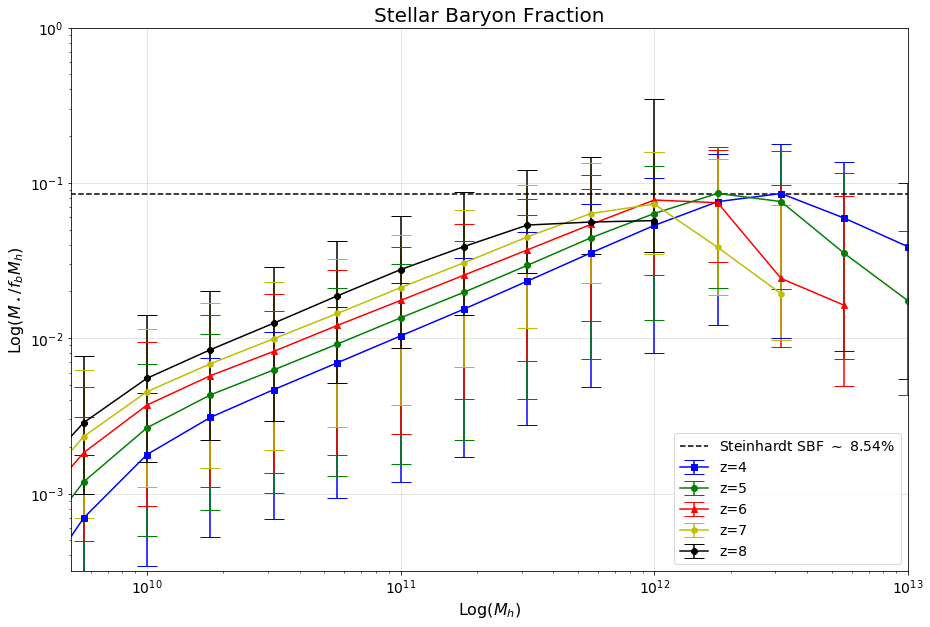

In [16]:
plt.figure(figsize=(15,10))
color = ['b','g','r','y','k']   
mark = ['s','o','^','h','8']
k = 0
smhm_berhoozi = [smhm_z4,smhm_z5,smhm_z6,smhm_z7,smhm_z8]
z_array = np.arange(4,9)
f_q = []
for z in z_array[:5]:
    smhm = smhm_berhoozi[k]
   
    mask = smhm['Q*'].values>0
    y = smhm['Q*'].values[mask]
    y_minus , y_plus = smhm['Err-Q*'].abs().values[mask],smhm['Err+Q*'].values[mask]
    x = smhm['#Log10(HM_Center)(0)'].values[mask]
    '''
    plt.errorbar(x,np.log10(y),
                 yerr=[np.log10(y) - np.log10(y-y_minus),np.log10(y+y_plus) - np.log10(y)],
                 color=color[k],marker=mark[k],label="z=%i"%(z))
    '''
    plt.errorbar(np.power(10,x),y,
                 yerr=[y_minus,y_plus],
                 color=color[k],marker=mark[k],label="z=%i"%(z), capsize=10)
    
    if k==0:
        smhm_merge = smhm.loc[:,['#Log10(HM_Center)(0)','Q*']]
        smhm_merge = smhm_merge.rename(columns={'Q*':'Q*_z4'})
        
    else:
        smhm_merge = pd.merge(smhm_merge,smhm.loc[:,['#Log10(HM_Center)(0)','Q*']],on=['#Log10(HM_Center)(0)'])
        smhm_merge = smhm_merge.rename(columns={'Q*':'Q*_z%i'%(z)})
    
    f_q.append(interp1d(smhm['#Log10(HM_Center)(0)'].values[mask],smhm['Q*'].values[mask]))
    k+=1


name = 'Steinhardt SBF $\sim$ %.2f'%(1/70/f_b*100)
plt.hlines(y=1/70/f_b,xmin=np.power(10,8.6),xmax=np.power(10,13.5),linestyles='dashed',label=name+'%')

                                     
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=4,fontsize=14)
plt.title("Stellar Baryon Fraction", fontsize=20)
plt.ylabel("Log$ (M_\star/f_bM_h)$", fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Log($M_h$)", fontsize=16)
plt.xticks(fontsize=14)

plt.xlim(np.power(10,9.7),np.power(10,13))
plt.ylim(np.power(10,-3.5),np.power(10,0))
plt.grid(True, alpha=0.4)
plt.show()

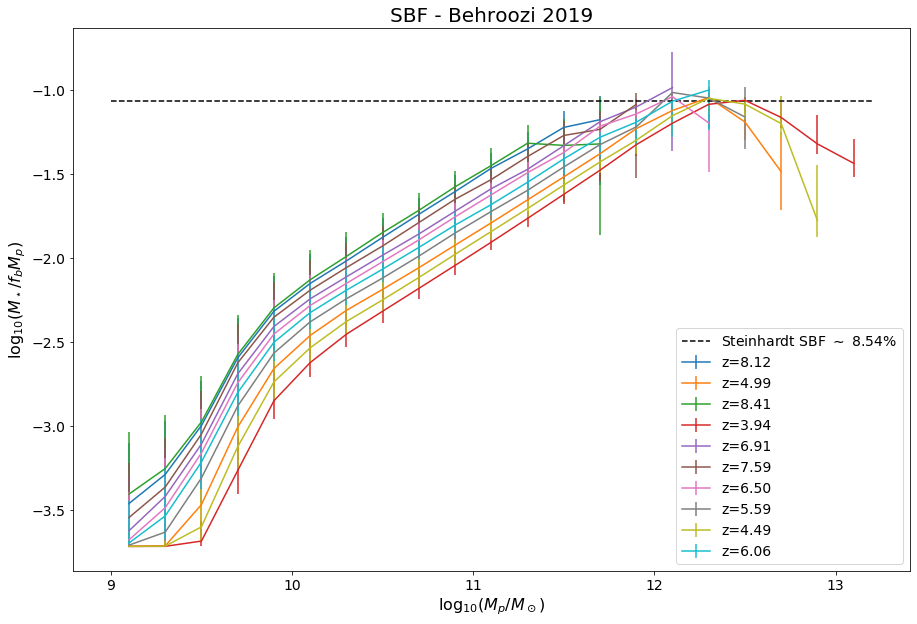

In [17]:
directory = 'umachine-dr1/data/smhm/median_raw/'
f_b = WMAP7.Ob(0) / WMAP7.Om(0)
count = 0
plt.figure(figsize=(15,10))
plt.title("SBF - Behroozi 2019",fontsize=20)
smhm_list = []
for f in os.scandir(directory):
    name = f.name
    if name.find('smhm_a')==0:
        smhm = pd.read_csv(directory+name, skiprows=0,sep="\s", engine='python')
        count+=1
        i = name.find('a0.') if name.find('a0.')>=0 else name.find('a1.')
        j = name.find('.dat')
        if i >=0 and j>=0:
            a =float(name[i+1:j])
            z = 1/a-1
            smhm.insert(0,'z',z)
            
            if count >1:
                smhm_merge = pd.concat([smhm_merge,smhm])
            else:
                smhm_merge = smhm
            
            if z>=3.5 and z<=8.5:
                smhm = smhm[smhm['Med_All(1)'].values<0]
                smhm.insert(2,'SBF',smhm['Med_All(1)'] -np.log10(f_b))
                plt.errorbar(smhm['#HM(0)'],smhm['SBF'],yerr=[smhm['Err-(3)'],smhm['Err+(2)']], label='z=%.2f'%z)
                smhm_list.append(smhm)

                
plt.ylabel("$\log_{10}(M_\star/f_bM_p)$", fontsize=16)
plt.xlabel("$\log_{10}(M_p/M_\odot)$", fontsize=16)
plt.yticks( fontsize=14)
plt.xticks(fontsize=14)
name = 'Steinhardt SBF $\sim$ %.2f'%(1/70/f_b*100)
plt.hlines(y=np.log10(1/70/f_b),xmin=9,xmax=13.2,linestyles='dashed',label=name+'%')
plt.legend(fontsize=14,loc=4)

In [18]:
plt.figure(figsize=(15,10))
color = ['b','g','r','y','k']   
mark = ['s','o','^','h','8']
k = 0
smhm = smhm_merge[(smhm_merge.iloc[:,1:]>0).product(axis=1).values.astype(bool)]
z_array = np.arange(4,9)
h = np.array([1]+[WMAP7.lookback_time(z_array[i]).value - WMAP7.lookback_time(z_array[i-1]).value for i in range(1,5)])
x = smhm['#Log10(HM_Center)(0)']
for i in range(1,5):
    dy = (smhm.iloc[:,i+1].values - smhm.iloc[:,i].values)/1
    plt.plot(x, dy,color=color[i],marker=mark[i],label="z=%i"%z_array[i])
plt.yscale('log')
plt.legend(loc=4,fontsize=14)
plt.title("Growth Stellar Baryon Fraction", fontsize=20)
plt.ylabel("d Q/d lookback time", fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Log($M_h$)", fontsize=16)
plt.xticks(fontsize=14)


plt.show()

KeyError: '#Log10(HM_Center)(0)'

<Figure size 1080x720 with 0 Axes>

In [ ]:
smhm.iloc[:,i].values - smhm.iloc[:,i-1].values

In [ ]:
!head 'umachine-dr1/observational_constraints/finkelstein_z3.5_z4.5.uvlf'

In [ ]:
cols = ['M_b','M_B','Log_N','Err+','Err-']

uvf_z4_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z3.5_z4.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z5_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z4.5_z5.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z6_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z5.5_z6.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z7_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z6.5_z7.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z8_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z7.5_z8.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')

## Abundance Matching

### Técnica $1/V_\max$

Seguiremos el trabajo de Berhoorzi et al. 2010 para este método. Primero es hayar la función de luminosidad de la muestra de galaxias analizadas, para ello seguiremos los métodos de Weigel et al. 2016. El primero de todo es la técnica basada en el volumen de comovimiento:
$$
\Phi_{j} \mathrm{d} \log M=\sum_{i}^{N_{\text {bin }}} \frac{w_{\text {spec }, i}}{V_{\text {max }, i}}
$$

Donde para el intervalo de magnitud $j$ tenemos que $N_{\text{bin}}$ es el número de la muestra en ese intervalo, $w_{\text{spec},i}$ es el complemento espectroscópico que tomaremos de Ilbert et al. 2005 y $V_{\text{max},i}$ es el volumen de comovimiento máximo, descrito como:
$$
V_{\max , i}=\frac{4 \pi}{3} \frac{\Omega^{\mathrm{s}}}{\Omega^{\mathrm{sky}}}\left(d_{\mathrm{c}}\left(z_{\max , i}\right)^{3}-d_{\mathrm{c}}\left(z_{\min , i}\right)^{3}\right)
$$

donde $\Omega^{\mathrm{sky}}$ es el área total del cielo $4\pi\ \mathrm{sr}\simeq 41253 \mathrm{deg}^2$, $\Omega^s$ es el área del estudio analizado, $d_c$ es la distancia de comovimiento, $z_{\min,i}$ es el redshift mínimo del estudio y $z_{\max,i}=\min \{z_{\max}^s,z_{\max,i}^{m}\}$ donde $z_{\max}^s$ es el redshift máximo del estudio y $z_{\max,i}^{m}$ es el redshift máximo al que se podría detectar la muestra $i$.

In [ ]:
def v_max(Omega_s,z_max,z_min,cos_model):
    d_max = cos_model.comoving_distance(z_max)
    d_min = cos_model.comoving_distance(z_min)
    Omega_sky = 4*np.pi *(180/np.pi)**2
    coef = (4*np.pi/3) * (Omega_s/Omega_sky)
    return coef * (d_max**3 - d_min**3)


Haciendo una prueba con los datos de Finkelstein et al. 2015a, donde el tamaño del estudio es de $\Omega^s=301 \mathrm{arcmin}^2 \simeq 0.0836 \mathrm{deg}^2$, por lo que si consideramos los intercalos de redhisft tomados en Fineklstein et al. 2015a y la cosmología con los parámetros de WMAP7 tenemos que:

In [ ]:
z_array = np.arange(4,9)
Omega_s = 310 * (1/60)**2
for z in z_array:
    z_max = z + 0.5
    z_min = z - 0.5
    v0 = v_max(Omega_s,z_max,z_min,WMAP7)
    print('Intervalo %.1f <z< %.1f --> V_max = %.2E Mpc^3' % (z_min,z_max,v0.value))

Usando los límites impuesto por cada uno de los intervalos de redshift, calculamos los $\Phi_j$ sin tener en cuenta $w_{\mathrm{spec},i}$ :

In [ ]:
d_L = (1+fink_a.zphot.values)*WMAP7.comoving_distance(fink_a.zphot.values).value
m_lim = np.max(fink_a['1500Mag'].values -5 +5 * np.array([np.log10(d) for d in d_L]))
m_lim

In [ ]:
uvf_berhoozi = [uvf_z4,uvf_z5,uvf_z6,uvf_z7,uvf_z8]
uvf_bouwens = [uvf_bw_z4,uvf_bw_z5,uvf_bw_z6]
uvf_finkelstein =[uvf_z4_fink,uvf_z5_fink,uvf_z6_fink,uvf_z7_fink,uvf_z8_fink]
#mags = uvf_bouwens[0]['M'].values
mags = np.arange(-22.5,-16.5)
z_array = np.arange(4,9)

phi = []
plt.figure(figsize=(15,10))
color = ['b','g','r','y','k']   
mark = ['s','o','^','h','8']
mark_2 = ['1','2','3','4','x']


def phi_k(table,z_max_s,z_min):
    
    phi = 0
    for i in range(table.shape[0]):
        M1500 = table.iloc[i,9]
        z_array = np.linspace(z_min,z_max_s,10)
        m_array = np.array([M1500 - 5 + 5*np.log10((1+z) * WMAP7.comoving_distance(z).value) for z in z_array])
        mask = m_array>=m_lim
        z_max = np.min(z_array[mask]) if z_array[mask].size > 0 else z_max_s
        v0 = v_max(Omega_s,z_max,z_min,WMAP7).value
        phi+= 1/v0
        if z_max < z_max_s:
            print('%f < %f'%(z_max,z_max_s))
    return phi

k = 0
for z in z_array[:5]:
    z_max_s = z + 0.5
    z_min = z - 0.5
    
    p = np.zeros(mags.size)
    i = 0
    for m in mags:
        m_max = m + 0.25
        m_min = m - 0.25
        mask = (fink_a.zphot.values >= z_min) & (fink_a.zphot.values < z_max_s) & (fink_a['1500Mag'].values >= m_min) & (fink_a['1500Mag'].values < m_max)
        table = fink_a[mask]
        p[i] = phi_k(table,z_max_s,z_min)
        i+=1
    phi.append(p)
    
    uvf = uvf_berhoozi[k]
    #uvf_bw = uvf_bouwens[k]
    uvf_fink = uvf_finkelstein[k]
    #plt.fill_between(uvf['#UV_Center'],np.log10(uvf['Number_Density']+ uvf['Err+']),np.log10(uvf['Number_Density'] - uvf['Err-']),color=color[k],alpha=0.5)
    #plt.plot(uvf['#UV_Center'], uvf['Number_Density'],c=color[k], label="Behroozi z=%i"%z)
    plt.errorbar((uvf_fink['M_b']+uvf_fink['M_B'])/2, uvf_fink['Log_N'],yerr=[uvf_fink['Err-'],uvf_fink['Err+']],color=color[k],marker=mark[k],label="Fink z=%i"%z)
    plt.plot(mags,np.log10(p), c=color[k],marker=mark_2[k],ls="dotted",label="Fink z=%i"%z)
    
    k+=1

#plt.yscale('log')
plt.legend(loc=0)
plt.show()
    

### Funciones de Behroozi

In [ ]:
#uvsm_z4, smhm_z4, hmf_z4, uvf_z4
#smhm_z4.insert(7,'Log_SFR',smhm_z4['Log_SMHM(4)']-np.log10(f_b))
smhm_z4

In [ ]:
#plt.fill_between(uvf_z4['#UV_Center'],uvf_z4['Number_Density']+uvf_z4['Err+'],uvf_z4['Number_Density']-uvf_z4['Err-'])
smf_test = pd.merge(hmf_z4.iloc[:,:4], smhm_z4.sort_values('#Log10(HM_Center)(0)').iloc[:,:4],left_on='#Log10(HM)', right_on='#Log10(HM_Center)(0)')
smf_test = smf_test.sort_values('Log_SM(1)')
smf_test

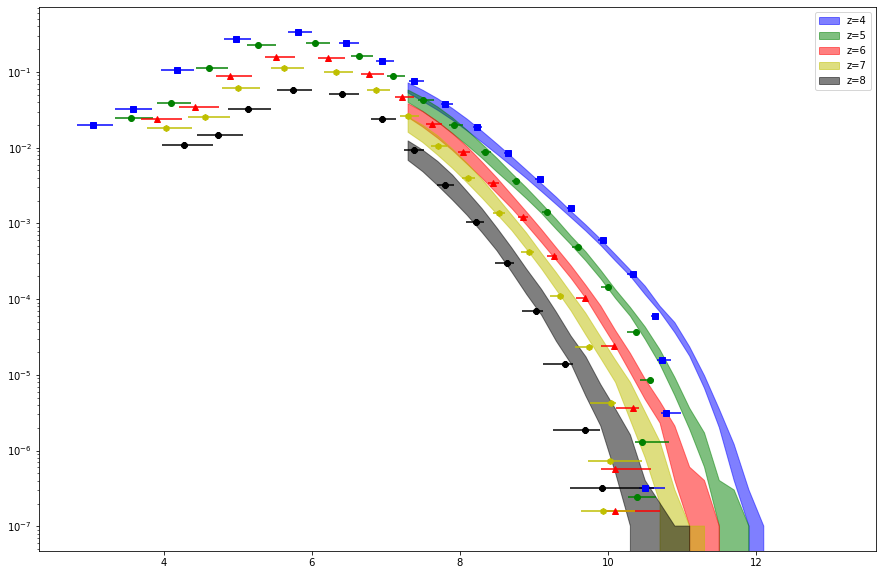

In [19]:
plt.figure(figsize=(15,10))
color = ['b','g','r','y','k']   
mark = ['s','o','^','h','8']
k = 0
smf_berhoozi = [smf_z4,smf_z5,smf_z6,smf_z7,smf_z8]
hmf_berhoozi = [hmf_z4,hmf_z5,hmf_z6,hmf_z7,hmf_z8]
smhm_berhoozi = [smhm_z4,smhm_z5,smhm_z6,smhm_z7,smhm_z8]

for z in z_array[:5]:
    smf = smf_berhoozi[k]
    smhm = smhm_berhoozi[k]
    hmf = hmf_berhoozi[k]
    smf_test = pd.merge(hmf.iloc[:,:4], smhm.sort_values('#Log10(HM_Center)(0)').iloc[:,:4],left_on='#Log10(HM)', right_on='#Log10(HM_Center)(0)')
    smf_test = smf_test.sort_values('Log_SM(1)')
    
    
    plt.fill_between(smf['#Log10(SM_Center)'],smf['Number_Density'] + smf['Err+'],
                     smf['Number_Density'] - smf['Err-'],alpha=0.5,color=color[k], label="z=%i"%z)


    plt.errorbar(smf_test['Log_SM(1)'].values,smf_test['Number_Density'].values,
                 xerr=[smf_test['Err-(3)'],smf_test['Err+(2)']],
                 yerr=[smf_test['Err-'].abs(),smf_test['Err+']],
                 color=color[k],marker=mark[k],linestyle="")
    k+=1
plt.yscale('log')
plt.legend(loc=0)
plt.show()

In [20]:
smf_test['Number_Density'] + smf_test['Err-']

0     1.078020e-02
1     1.460250e-02
2     3.200386e-02
3     5.719233e-02
4     5.056369e-02
5     2.394207e-02
6     9.358223e-03
7     3.250377e-03
8     1.047800e-03
9     2.979910e-04
10    6.874240e-05
11    1.408660e-05
12    1.851380e-06
13    3.219780e-07
dtype: float64

In [21]:
uvf = interp1d(uvf_z4['#UV_Center'], uvf_z4['Number_Density'])
uvf_b = interp1d(uvf_z4['#UV_Center'], uvf_z4['Number_Density']-uvf_z4['Err-'])
uvf_B = interp1d(uvf_z4['#UV_Center'], uvf_z4['Number_Density']+uvf_z4['Err+'])

uvsm = interp1d(uvsm_z4['Median_SM'], uvsm_z4['#UV_Center'])
uvsm_b = interp1d(uvsm_z4['Median_SM'], uvsm_z4['UV_Min'])
uvsm_B = interp1d(uvsm_z4['Median_SM'], uvsm_z4['UV_Max'])

smhm = interp1d(smhm_z4['#Log10(HM_Center)(0)'], smhm_z4['Log_SM(1)'])
smhm_b = interp1d(smhm_z4['#Log10(HM_Center)(0)'], smhm_z4['Log_SM(1)']-smhm_z4['Err-(3)'])
smhm_B = interp1d(smhm_z4['#Log10(HM_Center)(0)'], smhm_z4['Log_SM(1)']+smhm_z4['Err+(2)'])

h_m,h_M = smhm_z4['#Log10(HM_Center)(0)'].min(), smhm_z4['#Log10(HM_Center)(0)'].max()

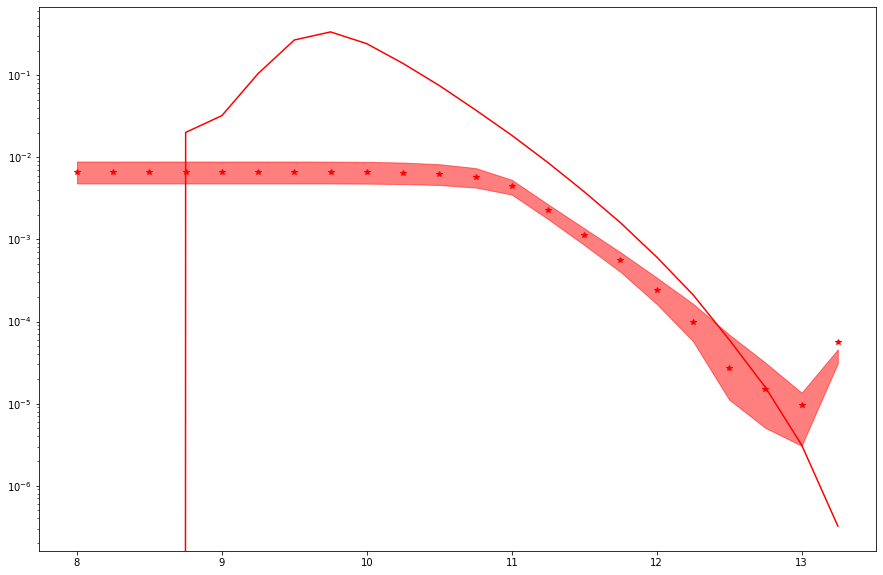

In [22]:
h = hmf_z4['#Log10(HM)'].values
mask = (h>=h_m) & (h<=h_M)
h = h[mask]
n = hmf_z4['Number_Density'].values[mask]
n_test = uvf(uvsm(np.power(10,smhm(h))))
n_b = uvf_b(uvsm_b(np.power(10,smhm_b(h))))
n_B = uvf_B(uvsm_B(np.power(10,smhm_B(h))))
plt.figure(figsize=(15,10))
plt.fill_between(h,n_B,n_b,alpha=0.5,color='r')
plt.plot(h,n,'r-')
plt.plot(h,n_test,'r*')
plt.yscale('log')


In [23]:
n_B>=n_b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

## Conversion UV SM

### Steinhardt - Función Luminosidad Bowens 2015


In [24]:
sfr=0.4
f_b = 0.16

uvf_bw_z4 = pd.read_csv("Bouwens 2015/bowensz4.csv", names=['M','phi','err_phi']) 
uvf_bw_z4['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z4.M.values - 4.62)))
uvf_bw_z4['Mass_Beh'] = np.log10(120 * 6.3/70 * np.power(10,-0.4 * (uvf_bw_z4.M.values - 4.62)))
uvf_bw_z4['Mass_SFR'] = np.log10(120 /(sfr*f_b) * np.power(10,-0.4 * (uvf_bw_z4.M.values - 4.62)))

uvf_bw_z5 = pd.read_csv("Bouwens 2015/bowensz5.csv", names=['M','phi','err_phi']) 
uvf_bw_z5['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z5.M.values - 4.62)))
uvf_bw_z5['Mass_Beh'] = np.log10(120 *6.3/70* np.power(10,-0.4 * (uvf_bw_z5.M.values - 4.62)))
uvf_bw_z5['Mass_SFR'] = np.log10(120 /(sfr*f_b)* np.power(10,-0.4 * (uvf_bw_z5.M.values - 4.62)))


uvf_bw_z6 = pd.read_csv("Bouwens 2015/bowensz6.csv", names=['M','phi','err_phi']) 
uvf_bw_z6['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z6.M.values - 4.62)))
uvf_bw_z6['Mass_Beh'] = np.log10(120 *6.3/70* np.power(10,-0.4 * (uvf_bw_z6.M.values - 4.62)))
uvf_bw_z6['Mass_SFR'] = np.log10(120 /(sfr*f_b)* np.power(10,-0.4 * (uvf_bw_z6.M.values - 4.62)))

uvf_bw_z7 = pd.read_csv("Bouwens 2015/bowensz7.csv", names=['M','phi','err_phi']) 
uvf_bw_z7['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z7.M.values - 4.62)))
uvf_bw_z7['Mass_Beh'] = np.log10(120 *6.3/70* np.power(10,-0.4 * (uvf_bw_z7.M.values - 4.62)))
uvf_bw_z7['Mass_SFR'] = np.log10(120 /(sfr*f_b)* np.power(10,-0.4 * (uvf_bw_z7.M.values - 4.62)))

uvf_bw_z8 = pd.read_csv("Bouwens 2015/bowensz8.csv", names=['M','phi','err_phi']) 
uvf_bw_z8['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z8.M.values - 4.62)))
uvf_bw_z8['Mass_Beh'] = np.log10(120 *6.3/70* np.power(10,-0.4 * (uvf_bw_z8.M.values - 4.62)))
uvf_bw_z8['Mass_SFR'] = np.log10(120 /(sfr*f_b)* np.power(10,-0.4 * (uvf_bw_z8.M.values - 4.62)))



In [25]:
!head -20 "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z4 .txt"

# [1] m:            [M_sun/h] 
# [2] sigma 
# [3] ln(1/sigma) 
# [4] n_eff 
# [5] f(sigma) 
# [6] dn/dm:        [h^4/(Mpc^3*M_sun)] 
# [7] dn/dlnm:      [h^3/Mpc^3] 
# [8] dn/dlog10m:   [h^3/Mpc^3] 
# [9] n(>m):        [h^3/Mpc^3] 
# [11] rho(>m):     [M_sun*h^2/Mpc^3] 
# [11] rho(<m):     [M_sun*h^2/Mpc^3] 
# [12] Lbox(N=1):   [Mpc/h]
1.000000000000000000e+10 9.726603757220000368e-01 2.772030631769818385e-02 -2.361242218390441128e+00 2.328657032825493245e-01 1.868038837938135518e-11 1.868038837938135466e-01 4.301318381370271005e-01 1.633383167220873733e-01 5.954789108574075699e+09 6.939732089142591858e+10 1.829380202186192905e+00
1.122018454301965332e+10 9.607672903753496918e-01 4.002305295142644104e-02 -2.356394020342361451e+00 2.288432394108978196e-01 1.469272414241812106e-11 1.648550763176114820e-01 3.795928412333279822e-01 1.430951997378285823e-01 5.740778605793642044e+09 6.961133139420635986e+10 1.911869793348386803e+00
1.258925411794171333e+10 9.489306580218549447e-01 5.24195515

In [26]:
archivos = ["HMFCalc/Seth_WMAP7/mVector_z=4 .txt","HMFCalc/Seth_WMAP7/mVector_z=5 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=6 .txt","HMFCalc/Seth_WMAP7/mVector_z=7 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=8 .txt"]

archivos3 = ["HMFCalc/Seth_Planck/mVector_PLANCK-SMT z4 .txt","HMFCalc/Seth_Planck/mVector_PLANCK-SMT z5 .txt",
           "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z6 .txt","HMFCalc/Seth_Planck/mVector_PLANCK-SMT z7 .txt",
           "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z8 .txt"]

archivos2 = ["HMFCalc/Beh-Planck/mVector_PLANCK- z = 4 .txt","HMFCalc/Beh-Planck/mVector_PLANCK- z = 5 .txt",
           "HMFCalc/Beh-Planck/mVector_PLANCK- z = 6 .txt","HMFCalc/Beh-Planck/mVector_PLANCK- z = 7 .txt",
           "HMFCalc/Beh-Planck/mVector_PLANCK- z = 8 .txt"]
hmfcalc_list=[]
hmfcalc_list2=[]

hmfcalc_list3=[]

h_list = [0.704,0.6704,0.6704]
for i in range(5):
    a = archivos[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12,engine='python')
    hmfcalc_z = hmfcalc_z.iloc[:,[0,6,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",6:"dn/dlnm",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values * h_list[0])
    hmfcalc_list.append(hmfcalc_z)
    
    a = archivos2[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12,engine='python')
    hmfcalc_z = hmfcalc_z.iloc[:,[0,6,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",6:"dn/dlnm",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values)
    hmfcalc_list2.append(hmfcalc_z)
    
    a = archivos3[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12,engine='python')
    hmfcalc_z = hmfcalc_z.iloc[:,[0,6,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",6:"dn/dlnm",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values)
    hmfcalc_list3.append(hmfcalc_z)

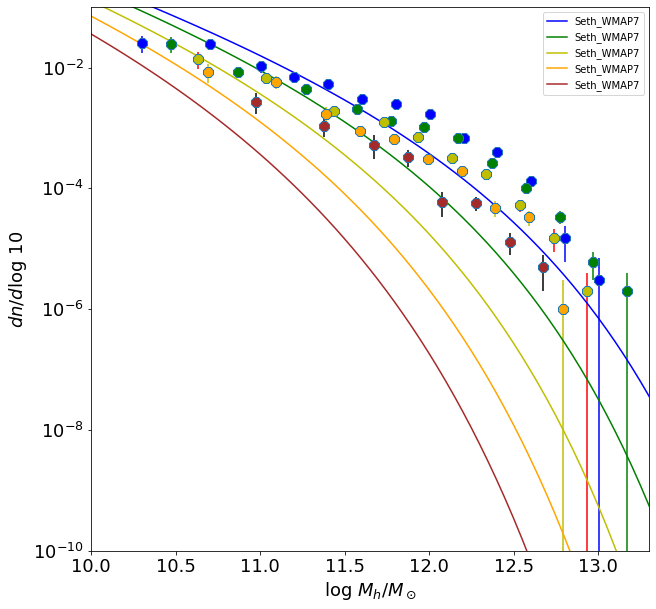

In [27]:
sfr=1
f_b = 0.16

uvf_bw_z4['Mass_SFR'] = np.log10(120 /(sfr*f_b)/70 * np.power(10,-0.4 * (uvf_bw_z4.M.values - 4.62)))

uvf_bw_z5['Mass_SFR'] = np.log10(120 /(sfr*f_b)/70* np.power(10,-0.4 * (uvf_bw_z5.M.values - 4.62)))

uvf_bw_z6['Mass_SFR'] = np.log10(120 /(sfr*f_b)/70* np.power(10,-0.4 * (uvf_bw_z6.M.values - 4.62)))

uvf_bw_z7['Mass_SFR'] = np.log10(120 /(sfr*f_b)/70* np.power(10,-0.4 * (uvf_bw_z7.M.values - 4.62)))

uvf_bw_z8['Mass_SFR'] = np.log10(120 /(sfr*f_b)/70* np.power(10,-0.4 * (uvf_bw_z8.M.values - 4.62)))


plt.figure(figsize=(10,10))
plt.errorbar(uvf_bw_z4.Mass,uvf_bw_z4.phi, uvf_bw_z4.err_phi,marker='8',ms=10, mfc='b',ecolor="b",linestyle="")
plt.errorbar(uvf_bw_z5.Mass,uvf_bw_z5.phi, uvf_bw_z5.err_phi,marker='8',ms=10, mfc='g',ecolor="g",linestyle="")
plt.errorbar(uvf_bw_z6.Mass,uvf_bw_z6.phi, uvf_bw_z6.err_phi,marker='8',ms=10, mfc='y',ecolor="r",linestyle="")
plt.errorbar(uvf_bw_z7.Mass,uvf_bw_z7.phi, uvf_bw_z7.err_phi,marker='8',ms=10, mfc='orange',ecolor="y",linestyle="")
plt.errorbar(uvf_bw_z8.Mass,uvf_bw_z8.phi, uvf_bw_z8.err_phi,marker='8',ms=10, mfc='brown',ecolor="k",linestyle="")
color = ['b','g','y','orange','brown']
color2 = ['b--','g--','y--','orange--','brown--']
color3 = ['b:','g:','y:','orange:','brown:']
hmf_um = [hmf_z4,hmf_z5,hmf_z6,hmf_z7,hmf_z8]
for i in range(5):
    
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i],label="Seth_WMAP7")
    
    '''
    h = hmfcalc_list2[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color2[i], label="Beh-Planck")
    
    h = hmfcalc_list3[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color3[i], label="Seth-Planck")
    
    '''
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])'''

#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')
plt.ylim(1e-10,1e-1)
plt.xlim(10,13.3)
plt.xlabel("$\log\ M_h/M_\odot$",fontsize=18)
plt.ylabel("$dn/d\log\ 10$",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.legend()
plt.savefig("test.png")

### Behroozi

In [28]:
# Usando las curvas de Behroozi
def conv_uvsm_sfr1(z):
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        bw = bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        bw = bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        bw = bw_z6.copy()
    else:
        return pd.DataFrame({})
    
    f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
    f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")
    
    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)
    bw['Mh'] = np.log10(bw['SM'] * 70)
    bw['Mh_B'] = np.log10(bw['SM_B'] * 70)
    bw['Mh_b'] = np.log10(bw['SM_b'] * 70)
    bw['Median_Mh'] = np.log10(bw['Median_SM'] * 70)
    
    return bw

def conv_uvsm_behroozi(z):
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        smhm = smhm_z4
        bw = bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        smhm = smhm_z4
        bw = bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        smhm = smhm_z4
        bw = bw_z6.copy()
    else:
        return pd.DataFrame({})
    
    f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
    g = interp1d(smhm['Log_SM(1)'].values,smhm['#Log10(HM_Center)(0)'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
    f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
    g_b = interp1d(smhm['Err+(2)'].values,smhm['#Log10(HM_Center)(0)'].values)
    g_B = interp1d(smhm[ 'Err-(3)'].values,smhm['#Log10(HM_Center)(0)'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")
    
    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)
    
    bw['Mh'] = g(np.log10(bw['SM']))
    bw['Mh_B'] = g_B(np.log10(bw['SM_B']))
    bw['Mh_b'] = g_b(np.log10(bw['SM_b']))
    bw['Median_Mh'] = g(np.log10(bw['Median_SM']))
    
    return bw

In [29]:
hmsm_z4=pd.read_csv("umachine-dr1/data/smhm/averages/hm_averages_a0.202435.dat", skiprows=6,sep="\s", engine='python')
hmsm_z5=pd.read_csv("umachine-dr1/data/smhm/averages/hm_averages_a0.166998.dat", skiprows=6,sep="\s", engine='python')
hmsm_z6=pd.read_csv("umachine-dr1/data/smhm/averages/hm_averages_a0.141685.dat", skiprows=6,sep="\s", engine='python')
hmsm_z7=pd.read_csv("umachine-dr1/data/smhm/averages/hm_averages_a0.126498.dat", skiprows=6,sep="\s", engine='python')
hmsm_z8=pd.read_csv("umachine-dr1/data/smhm/averages/hm_averages_a0.109623.dat", skiprows=6,sep="\s", engine='python')

hmsm_z4.columns

Index(['#Log10(SM_Center)(0)', '<Mh>(1)', 'Err+(2)', 'Err-(3)', '<Log(Mh)>(4)',
       'Err+(5)', 'Err-(6)', '<WL(Mh)>(7)', 'Err+(8)', 'Err-(9)', '<Mh>(10)',
       'Err+(11)', 'Err-(12)', '<Log(Mh)>(13)', 'Err+(14)', 'Err-(15)',
       '<WL(Mh)>(16)', 'Err+(17)', 'Err-(18)', '<Mh>(19)', 'Err+(20)',
       'Err-(21)', '<Log(Mh)>(22)', 'Err+(23)', 'Err-(24)', '<WL(Mh)>(25)',
       'Err+(26)', 'Err-(27)', '<Mh>(28)', 'Err+(29)', 'Err-(30)',
       '<Log(Mh)>(31)', 'Err+(32)', 'Err-(33)', '<WL(Mh)>(34)', 'Err+(35)',
       'Err-(36)', '<Mh>(37)', 'Err+(38)', 'Err-(39)', '<Log(Mh)>(40)',
       'Err+(41)', 'Err-(42)', '<WL(Mh)>(43)', 'Err+(44)', 'Err-(45)',
       '<Mh>(46)', 'Err+(47)', 'Err-(48)', '<Log(Mh)>(49)', 'Err+(50)',
       'Err-(51)', '<WL(Mh)>(52)', 'Err+(53)', 'Err-(54)', '<Mh>(55)',
       'Err+(56)', 'Err-(57)', '<Log(Mh)>(58)', 'Err+(59)', 'Err-(60)',
       '<WL(Mh)>(61)', 'Err+(62)', 'Err-(63)', '(64)', 'HM_Left_Edge(65)',
       'HM_Right_Edge(66)', 'Bestfit_Galaxy_Cou

In [32]:
uvsm = uvsm_z4
hmsm = hmsm_z4
hmsm = hmsm[hmsm>0]
bw = uvf_bw_z4.copy()
uvsm = uvsm[uvsm.Median_SM > 0]
bw = bw[(bw.M.values >= uvsm['#UV_Center'].values.min()) &  (bw.M.values <= uvsm['#UV_Center'].values.max())]


f = interp1d(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values))
g = interp1d(hmsm['#Log10(SM_Center)(0)'].values,hmsm['<Log(Mh)>(4)'].values)
f_B = interp1d(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values + uvsm['Err+'].values) - np.log10(uvsm['Median_SM'].values))
f_b = interp1d(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values) - np.log10(uvsm['Median_SM'].values - uvsm['Err-'].values))
g_b = interp1d(hmsm['#Log10(SM_Center)(0)'].values,hmsm['Err+(5)'].values)
g_B = interp1d(hmsm[ '#Log10(SM_Center)(0)'].values,hmsm['Err-(6)'].values)
bw['#UV_Center'] = bw.M - bw.M % 0.25
bw = pd.merge(bw,uvsm, on="#UV_Center")

bw['SM'] = f(bw.M.values)
bw['SM_B'] = f_B(bw.M.values)
bw['SM_b'] = f_b(bw.M.values)


bw = bw[(bw.SM.values >= hmsm['#Log10(SM_Center)(0)'].values.min()) &  (bw.SM.values <= hmsm['#Log10(SM_Center)(0)'].values.max())]
bw = bw[(bw.SM.values + bw.SM_B.values >= hmsm['#Log10(SM_Center)(0)'].values.min()) &  (bw.SM.values + bw.SM_B.values <= hmsm['#Log10(SM_Center)(0)'].values.max())]
bw = bw[(bw.SM.values - bw.SM_b.values >= hmsm['#Log10(SM_Center)(0)'].values.min()) &  (bw.SM.values - bw.SM_b.values <= hmsm['#Log10(SM_Center)(0)'].values.max())]

bw['Mh'] = g(bw['SM'])
bw['Mh_B'] = g_B(bw.SM.values + bw['SM_B'])
bw['Mh_b'] = g_b(bw.SM.values - bw['SM_b'])
bw['Median_Mh'] = g(np.log10(bw['Median_SM']))

bw

,M,phi,err_phi,Mass,Mass_Beh,Mass_SFR,#UV_Center,Median_SM,Err+,Err-,UV_Min,UV_Max,SM,SM_B,SM_b,Mh,Mh_B,Mh_b,Median_Mh
0,-22.69,0.000003,0.000004,13.003181,11.957424,11.953963,-22.75,8.031020e+10,9.450800e+09,2.238510e+10,-23.0,-22.5,10.870321,0.045675,0.140218,12.289721,0.003300,0.044210,12.303756
1,-22.19,0.000015,0.000009,12.803181,11.757424,11.753963,-22.25,4.146550e+10,2.588320e+09,1.057430e+10,-22.5,-22.0,10.576947,0.026524,0.126759,12.151983,0.008090,0.037281,12.174634
2,-21.69,0.000134,0.000023,12.603181,11.557424,11.553963,-21.75,1.897540e+10,1.272490e+09,4.539430e+09,-22.0,-21.5,10.235546,0.029190,0.114093,11.960576,0.008364,0.034720,11.985800
3,-21.19,0.000393,0.000040,12.403181,11.357424,11.353963,-21.25,8.371810e+09,7.346360e+08,1.408040e+09,-21.5,-21.0,9.884833,0.038159,0.078990,11.762233,0.011256,0.031286,11.783482
4,-20.69,0.000678,0.000063,12.203181,11.157424,11.153963,-20.75,4.038910e+09,4.939580e+08,6.151670e+08,-21.0,-20.5,9.572155,0.051973,0.070355,11.580674,0.015449,0.032609,11.600611
5,-20.19,0.001696,0.000113,12.003181,10.957424,10.953963,-20.25,2.099030e+09,3.425160e+08,2.709780e+08,-20.5,-20.0,9.290802,0.066968,0.059549,11.418308,0.021687,0.027837,11.436161
6,-19.69,0.002475,0.000185,11.803181,10.757424,10.753963,-19.75,1.153130e+09,2.226250e+08,1.395580e+08,-20.0,-19.5,9.033383,0.077443,0.055791,11.272262,0.030522,0.027060,11.288661
7,-19.19,0.002984,0.000255,11.603181,10.557424,10.553963,-19.25,6.674500e+08,1.408660e+08,7.815730e+07,-19.5,-19.0,8.797755,0.084102,0.053691,11.136045,0.039361,0.029187,11.151549
8,-18.69,0.005352,0.000446,11.403181,10.357424,10.353963,-18.75,4.001490e+08,9.326320e+07,4.415600e+07,-19.0,-18.5,8.576819,0.091428,0.050519,11.006216,0.048916,0.031419,11.021266
9,-18.19,0.006865,0.001043,11.203181,10.157424,10.153963,-18.25,2.457740e+08,5.985040e+07,2.602390e+07,-18.5,-18.0,8.366071,0.094923,0.048527,10.881280,0.058357,0.033426,10.895788


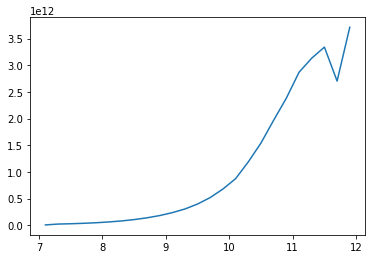

In [33]:
plt.plot(hmsm['#Log10(SM_Center)(0)'],hmsm['<Mh>(1)'])

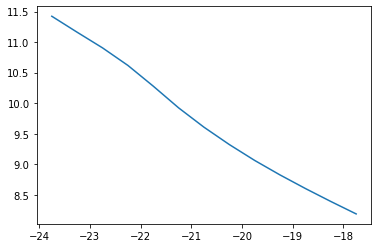

In [34]:
plt.plot(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values))

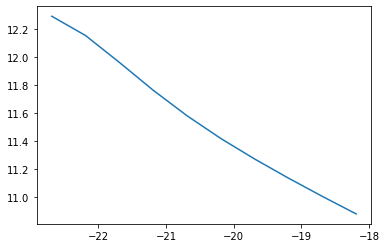

In [35]:
plt.plot(bw.M,bw.Mh)

In [36]:
# Usando las curvas de Behroozi


def conv_uvhm_behroozi(z):
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        hmsm = hmsm_z4
        bw = uvf_bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        hmsm = hmsm_z5
        bw = uvf_bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        hmsm = hmsm_z6
        bw = uvf_bw_z6.copy()
    elif z>=6.5 and z<7.5:
        uvsm = uvsm_z7
        hmsm = hmsm_z7
        bw = uvf_bw_z7.copy()
    elif z>=7.5 and z<8.5:
        uvsm = uvsm_z8
        hmsm = hmsm_z8
        bw = uvf_bw_z8.copy()
    else:
        return pd.DataFrame({})
    
    hmsm = hmsm[hmsm>0]
    bw = bw[(bw.M.values >= uvsm['#UV_Center'].values.min()) &  (bw.M.values <= uvsm['#UV_Center'].values.max())]
    f = interp1d(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values))
    g = interp1d(hmsm['#Log10(SM_Center)(0)'].values,hmsm['<Log(Mh)>(4)'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values + uvsm['Err+'].values) - np.log10(uvsm['Median_SM'].values))
    f_b = interp1d(uvsm['#UV_Center'].values,np.log10(uvsm['Median_SM'].values) - np.log10(uvsm['Median_SM'].values - uvsm['Err-'].values))
    g_b = interp1d(hmsm['#Log10(SM_Center)(0)'].values,hmsm['Err+(5)'].values)
    g_B = interp1d(hmsm[ '#Log10(SM_Center)(0)'].values,hmsm['Err-(6)'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")

    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)


    bw = bw[(bw.SM.values >= hmsm['#Log10(SM_Center)(0)'].values.min()) &  (bw.SM.values <= hmsm['#Log10(SM_Center)(0)'].values.max())]
    bw = bw[(bw.SM.values + bw.SM_B.values >= hmsm['#Log10(SM_Center)(0)'].values.min()) &  (bw.SM.values + bw.SM_B.values <= hmsm['#Log10(SM_Center)(0)'].values.max())]
    bw = bw[(bw.SM.values - bw.SM_b.values >= hmsm['#Log10(SM_Center)(0)'].values.min()) &  (bw.SM.values - bw.SM_b.values <= hmsm['#Log10(SM_Center)(0)'].values.max())]

    bw['Mh'] = g(bw['SM'])
    bw['Mh_B'] = g_B(bw.SM.values + bw['SM_B'])
    bw['Mh_b'] = g_b(bw.SM.values - bw['SM_b'])
    bw['Median_Mh'] = g(np.log10(bw['Median_SM']))
    
    return bw

In [37]:
bz4 = conv_uvhm_behroozi(4)
bz5 = conv_uvhm_behroozi(5)
bz6 = conv_uvhm_behroozi(6)
bz7 = conv_uvhm_behroozi(7)
bz8 = conv_uvhm_behroozi(8)
bz4

,M,phi,err_phi,Mass,Mass_Beh,Mass_SFR,#UV_Center,Median_SM,Err+,Err-,UV_Min,UV_Max,SM,SM_B,SM_b,Mh,Mh_B,Mh_b,Median_Mh
0,-22.69,0.000003,0.000004,13.003181,11.957424,11.953963,-22.75,8.031020e+10,9.450800e+09,2.238510e+10,-23.0,-22.5,10.870321,0.045675,0.140218,12.289721,0.003300,0.044210,12.303756
1,-22.19,0.000015,0.000009,12.803181,11.757424,11.753963,-22.25,4.146550e+10,2.588320e+09,1.057430e+10,-22.5,-22.0,10.576947,0.026524,0.126759,12.151983,0.008090,0.037281,12.174634
2,-21.69,0.000134,0.000023,12.603181,11.557424,11.553963,-21.75,1.897540e+10,1.272490e+09,4.539430e+09,-22.0,-21.5,10.235546,0.029190,0.114093,11.960576,0.008364,0.034720,11.985800
3,-21.19,0.000393,0.000040,12.403181,11.357424,11.353963,-21.25,8.371810e+09,7.346360e+08,1.408040e+09,-21.5,-21.0,9.884833,0.038159,0.078990,11.762233,0.011256,0.031286,11.783482
4,-20.69,0.000678,0.000063,12.203181,11.157424,11.153963,-20.75,4.038910e+09,4.939580e+08,6.151670e+08,-21.0,-20.5,9.572155,0.051973,0.070355,11.580674,0.015449,0.032609,11.600611
5,-20.19,0.001696,0.000113,12.003181,10.957424,10.953963,-20.25,2.099030e+09,3.425160e+08,2.709780e+08,-20.5,-20.0,9.290802,0.066968,0.059549,11.418308,0.021687,0.027837,11.436161
6,-19.69,0.002475,0.000185,11.803181,10.757424,10.753963,-19.75,1.153130e+09,2.226250e+08,1.395580e+08,-20.0,-19.5,9.033383,0.077443,0.055791,11.272262,0.030522,0.027060,11.288661
7,-19.19,0.002984,0.000255,11.603181,10.557424,10.553963,-19.25,6.674500e+08,1.408660e+08,7.815730e+07,-19.5,-19.0,8.797755,0.084102,0.053691,11.136045,0.039361,0.029187,11.151549
8,-18.69,0.005352,0.000446,11.403181,10.357424,10.353963,-18.75,4.001490e+08,9.326320e+07,4.415600e+07,-19.0,-18.5,8.576819,0.091428,0.050519,11.006216,0.048916,0.031419,11.021266
9,-18.19,0.006865,0.001043,11.203181,10.157424,10.153963,-18.25,2.457740e+08,5.985040e+07,2.602390e+07,-18.5,-18.0,8.366071,0.094923,0.048527,10.881280,0.058357,0.033426,10.895788


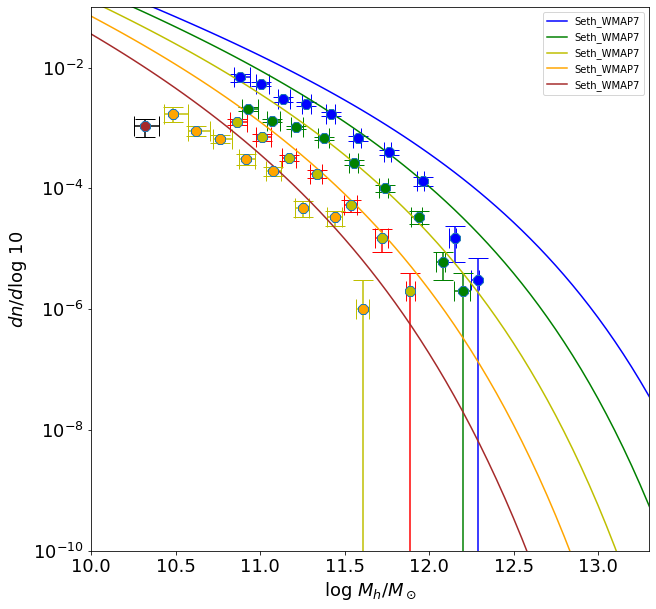

In [38]:
plt.figure(figsize=(10,10))
plt.errorbar(bz4.Mh,bz4.phi,xerr=[bz4.Mh_b,bz4.Mh_B] ,yerr=[bz4.err_phi,bz4.err_phi],marker='8',ms=10, mfc='b',ecolor="b",linestyle="", capsize=10)
plt.errorbar(bz5.Mh,bz5.phi,xerr=[bz5.Mh_b,bz5.Mh_B] ,yerr=[bz5.err_phi,bz5.err_phi],marker='8',ms=10, mfc='g',ecolor="g",linestyle="", capsize=10)
plt.errorbar(bz6.Mh,bz6.phi,xerr=[bz6.Mh_b,bz6.Mh_B] ,yerr=[bz6.err_phi,bz6.err_phi],marker='8',ms=10, mfc='y',ecolor="r",linestyle="", capsize=10)
plt.errorbar(bz7.Mh,bz7.phi,xerr=[bz7.Mh_b,bz7.Mh_B] ,yerr=[bz7.err_phi,bz7.err_phi],marker='8',ms=10, mfc='orange',ecolor="y",linestyle="", capsize=10)
plt.errorbar(bz8.Mh,bz8.phi,xerr=[bz8.Mh_b,bz8.Mh_B] ,yerr=[bz8.err_phi,bz8.err_phi],marker='8',ms=10, mfc='brown',ecolor="k",linestyle="", capsize=10)
color = ['b','g','y','orange','brown']
color2 = ['b--','g--','y--','orange--','brown--']
color3 = ['b:','g:','y:','orange:','brown:']
hmf_um = [hmf_z4,hmf_z5,hmf_z6,hmf_z7,hmf_z8]
for i in range(5):
    
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i],label="Seth_WMAP7")
    
    '''
    h = hmfcalc_list2[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color2[i], label="Beh-Planck")
    
    h = hmfcalc_list3[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color3[i], label="Seth-Planck")
    
    '''
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])'''

#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')
plt.ylim(1e-10,1e-1)
plt.xlim(10,13.3)
plt.xlabel("$\log\ M_h/M_\odot$",fontsize=18)
plt.ylabel("$dn/d\log\ 10$",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.legend()
plt.savefig("bw_behroozi.png")

In [ ]:
# Luminosity Function Bouwens 2015
'''
z4 =[
"-22.69,0.000003,0.000004",
"-22.19,0.000015,0.000009",
"-21.69,0.000134,0.000023",
"-21.19,0.000393,0.000040",
"-20.69,0.000678,0.000063",
"-20.19,0.001696,0.000113",
"-19.69,0.002475,0.000185",
"-19.19,0.002984,0.000255",
"-18.69,0.005352,0.000446",
"-18.19,0.006865,0.001043",
"-17.69,0.010473,0.002229",
"-16.94,0.024580,0.003500",
"-15.94,0.025080,0.007860"]



z5 = [
"-23.11,0.000002,0.000002",
"-22.61,0.000006,0.000003",
"-22.11,0.000034,0.000008",
"-21.61,0.000101,0.000014",
"-21.11,0.000265,0.000025",
"-20.61,0.000676,0.000046",
"-20.11,0.001029,0.000067",
"-19.61,0.001329,0.000094",
"-19.11,0.002085,0.000171",
"-18.36,0.004460,0.000540",
"-17.36,0.008600,0.001760",
"-16.36,0.024400,0.007160",
]

z6 = [
"-22.52,0.000002,0.000002",
"-22.02,0.000015,0.000006",
"-21.52,0.000053,0.000012",
"-21.02,0.000176,0.000025",
"-20.52,0.000320,0.000041",
"-20.02,0.000698,0.000083",
"-19.52,0.001246,0.000137",
"-18.77,0.001900,0.000320",
"-17.77,0.006680,0.001380",
"-16.77,0.013640,0.004200"
]


z7_ap = [
"-22.66, 0 , 0",
"-22.16, 0.000002,0.000003",
"-21.66, 0.000024,0.000009",
"-21.16, 0.000045,0.000017",
"-20.66, 0.000189,0.000037",
"-20.16, 0.000293,0.000060",
"-19.66, 0.000645,0.000099",
"-19.16, 0.000740,0.000158",
"-18.66, 0.001566,0.000431",
"-17.91, 0.005300,0.001320",
"-16.91, 0.007720,0.002680"
]

z7 = ["-22.66,0, 0",
"-22.16,0.000001,0.000002",
"-21.66,0.000033,0.000009",
"-21.16,0.000048,0.000015",
"-20.66,0.000193,0.000034",
"-20.16,0.000309,0.000061",
"-19.66,0.000654,0.000100",
"-19.16,0.000907,0.000177",
"-18.66,0.001717,0.000478",
"-17.91,0.005840,0.001460",
"-16.91,0.008500,0.002940"]

z8_ap = [
"-22.35, 0, 0",
"-21.85, 0, 0",
"-21.35, 0.000019,0.000007",
"-20.85, 0.000054,0.000016",
"-20.35, 0.000060,0.000026",
"-19.85, 0.000320,0.000100",
"-19.35, 0.000497,0.000212",
"-18.60, 0.001020,0.000340",
"-17.60, 0.002620,0.001000",
]

z8 = [
"-22.87, 0, 0",
"-22.37, 0, 0",
"-21.87, 0.000005,0.000003",
"-21.37, 0.000013,0.000005",
"-20.87, 0.000058,0.000015",
"-20.37, 0.000060,0.000026",
"-19.87, 0.000331,0.000104",
"-19.37, 0.000533,0.000226",
"-18.62, 0.001060,0.000340",
"-17.62, 0.002740,0.001040"
]

w = open('Bouwens 2015/bowensz4.csv','w')
for l in z4:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz5.csv','w')
for l in z5:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz6.csv','w')
for l in z6:
    w.write(l+'\n')
w.close()


w = open('Bouwens 2015/bowensz7.csv','w')
for l in z7:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz8.csv','w')
for l in z8:
    w.write(l+'\n')
w.close()

'''

In [87]:
z8 = [
"-22.87, 0, 0",
"-22.37, 0, 0",
"-21.87, 0.000005,0.000003",
"-21.37, 0.000013,0.000005",
"-20.87, 0.000058,0.000015",
"-20.37, 0.000060,0.000026",
"-19.87, 0.000331,0.000104",
"-19.37, 0.000533,0.000226",
"-18.62, 0.001060,0.000340",
"-17.62, 0.002740,0.001040"
]

w = open('Bouwens 2015/bowensz8.csv','w')
for l in z8:
    w.write(l+'\n')
w.close()